# Importing Liberaries

In [1]:
import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# %matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Rice.csv')
# parse strings to datetime type
dataset['Year'] = dataset['Year'].astype(str)
# df = dataset['Years'].apply(lambda x:int(x))
# df

In [3]:
dataset.head()

,Year,Area
0,1970,35958.0
1,1971,36087.0
2,1972,35075.0
3,1973,36488.0
4,1974,35958.0


In [4]:
dataset.count()
# dataset = dataset[:-1]

Year    50
Area    50
dtype: int64

In [5]:
dataset['Year'] = pd.to_datetime(dataset['Year'])
indexedDataset = dataset.set_index(['Year'])


In [6]:
indexedDataset.head()

,Area
Year,
1970-01-01,35958.0
1971-01-01,36087.0
1972-01-01,35075.0
1973-01-01,36488.0
1974-01-01,35958.0


# Data Visualisation

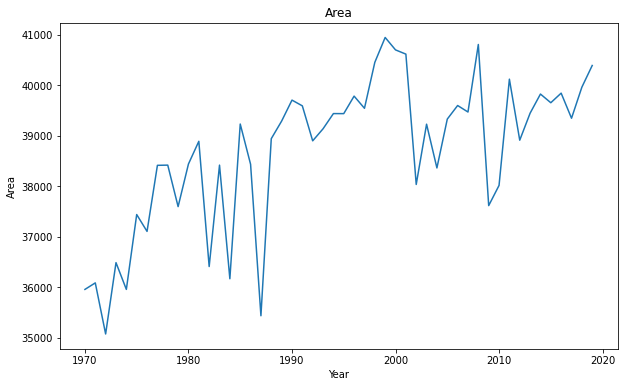

In [7]:
# draw lineplot
sns.lineplot(x="Year", y="Area", data=dataset).set(title='Area')
plt.show()


# Decomposing Time Series

<Figure size 720x432 with 0 Axes>

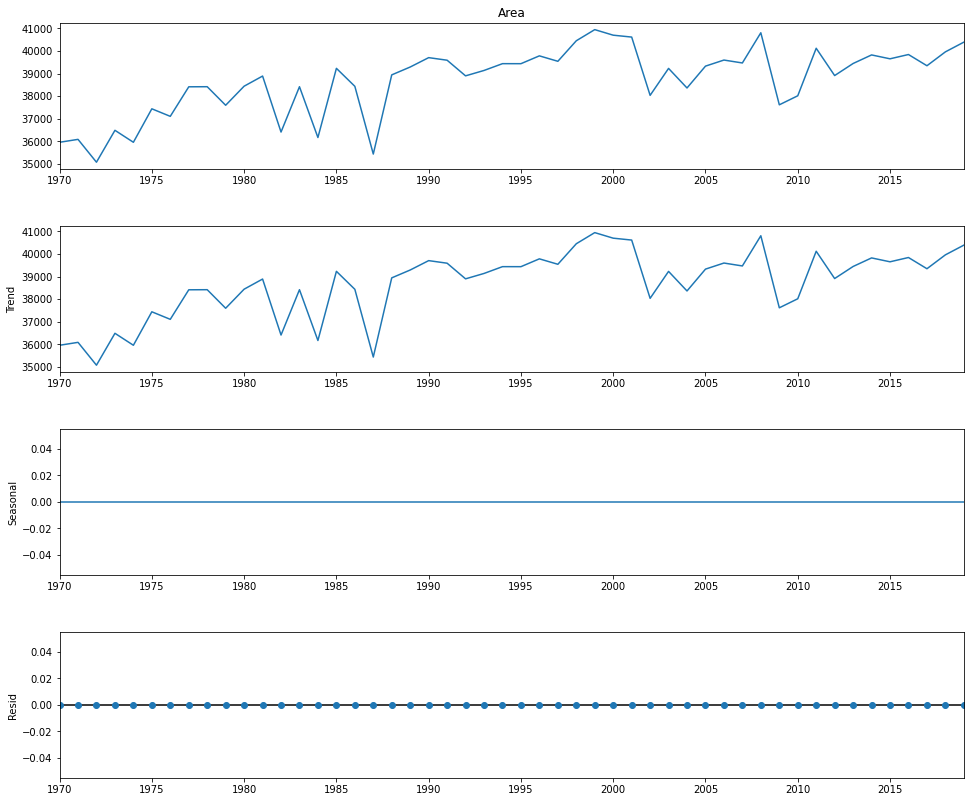

In [8]:
#Seasonal decomposition using moving averages
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(indexedDataset['Area'], model='additive', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

# Checking Stationarity

Dickey-Fuller Test
- A stationary time series is one whose properties do not depend on the time at which the series is observed.

In [9]:
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(indexedDataset['Area'])

p-value = 0.1031. The series is likely non-stationary.
Test Statistic                 -2.553101
p-value                         0.103083
#Lags Used                      2.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


- Since p value is greater than 0.05. Hence the series is non-stationary

## Converting into stationary

p-value = 0.0000. The series is likely stationary.
Test Statistic                 -5.354336
p-value                         0.000004
#Lags Used                      3.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


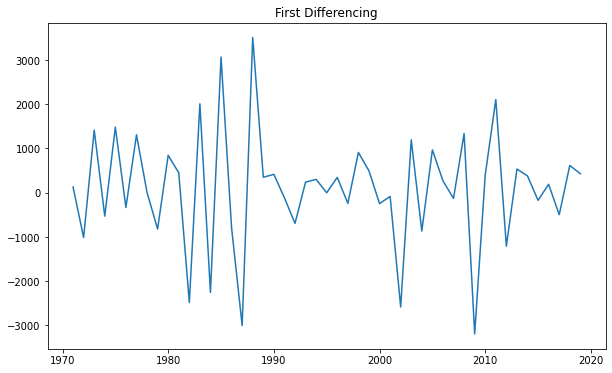

In [11]:
first_diff = indexedDataset.Area - indexedDataset.Area.shift(1)
plt.plot(first_diff)
plt.title("First Differencing")
first_diff = first_diff.dropna(inplace = False)
# print(first_diff.head())
dickey_fuller_test(first_diff, window = 12)

# Data Spliting

In [33]:
size = int(0.80*len(indexedDataset))
train_df = indexedDataset[:size]
test_df  = indexedDataset[size:]

length = len(indexedDataset)
length_train = len(train_df)
length_test = len(test_df)

In [25]:
train_df.count()

Area    40
dtype: int64

In [26]:
test_df.head()

,Area
Year,
2010-01-01,38018.0
2011-01-01,40123.0
2012-01-01,38914.0
2013-01-01,39449.0
2014-01-01,39828.0


Text(0, 0.5, 'CWL')

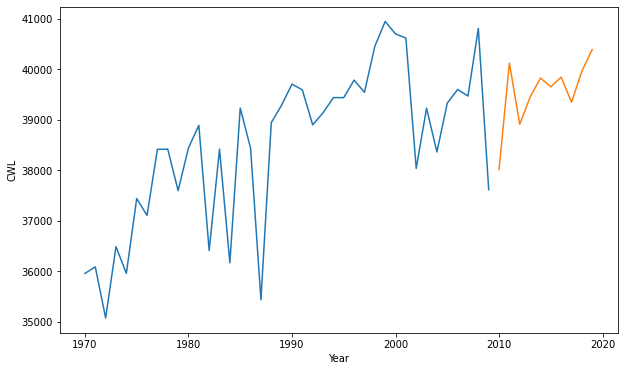

In [27]:
plt.plot(train_df)
plt.plot(test_df)
plt.xlabel('Year')
plt.ylabel('CWL')

# Ploting ACF and PACF

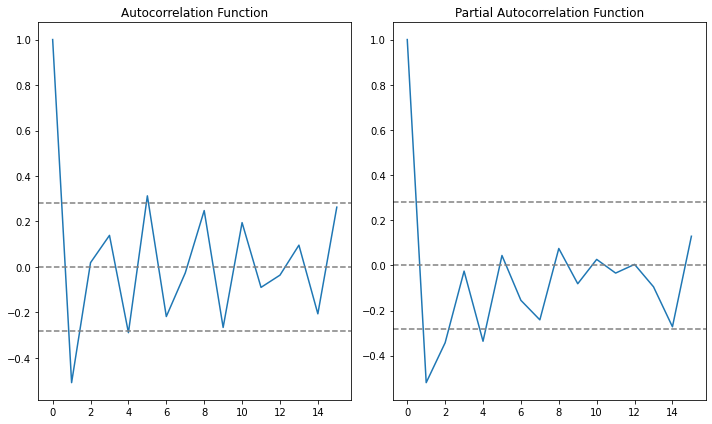

In [28]:
# an only compute partial correlations for lags up to 50% of the sample size. Hence nlag = 40//2 = 20
lag_acf = acf(first_diff,nlags=15)
lag_pacf = pacf(first_diff,nlags=15)

# The axhline() function in pyplot module of matplotlib library is used to add a horizontal line across the axis.

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray') #Formula of CI = 1.96* sqrt(n)
plt.axhline(y=1.96/np.sqrt(len(first_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

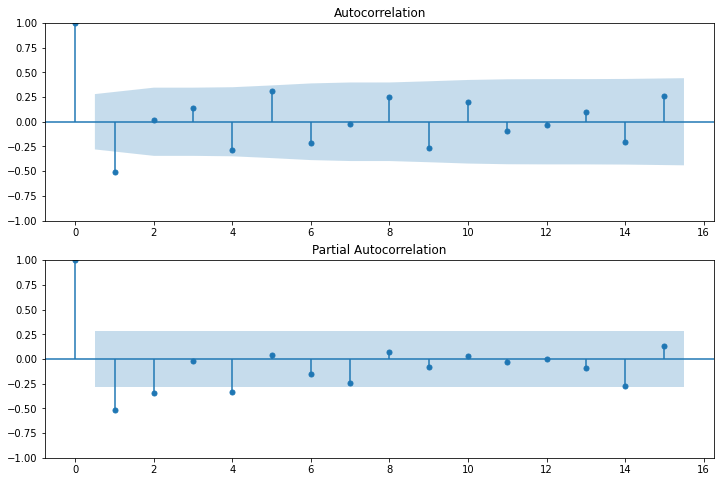

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=15, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=15, ax=ax2)

## Auto Arima for Estimating Parameters

In [31]:
from pmdarima import auto_arima

fit = auto_arima(train_df, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=681.289, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=682.120, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=683.504, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=679.324, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=685.775, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.385 seconds


# ARIMA Model

In [34]:
arima_model = sm.tsa.arima.ARIMA(endog = train_df,order=(0, 1, 0))
ar_model= arima_model.fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Area   No. Observations:                   40
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -338.662
Date:                Tue, 22 Nov 2022   AIC                            679.324
Time:                        18:22:14   BIC                            680.987
Sample:                    01-01-1970   HQIC                           679.921
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.041e+06   4.12e+05      4.951      0.000    1.23e+06    2.85e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.77   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.00   Prob(JB):                         0.70
Heteroskedasticity (H):               1.21   Skew:                            -0.19
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The P-Value should be less than 0.05, ideally for the corresponding X to be significant.

## Forecast

In [35]:
start_index = length_train+1
end_index= length
predicted_arima = ar_model.predict(start = start_index, end = end_index)
print(predicted_arima.head())

2011-01-01    37618.0
2012-01-01    37618.0
2013-01-01    37618.0
2014-01-01    37618.0
2015-01-01    37618.0
Freq: AS-JAN, Name: predicted_mean, dtype: float64


Text(0.5, 1.0, 'CWL (SARIMA)')

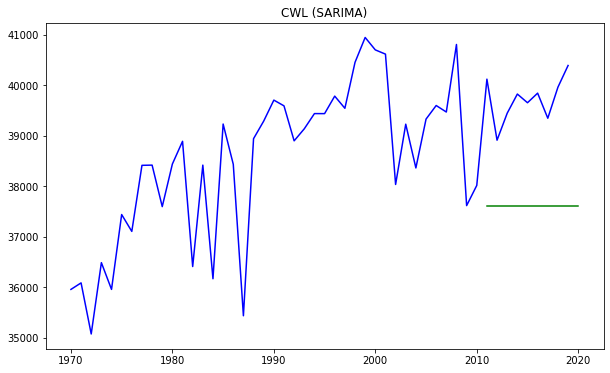

In [36]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_arima,color='green')
plt.title("CWL (SARIMA)")

In [37]:
def error(y_true, y_pred):
    mad = np.mean(abs((y_true-y_pred)))
    MSE = np.mean(np.square((y_true-y_pred)))
    RMSE = np.sqrt(MSE)
    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('MAD: %.2f  \nRMSE: %.2f \nMAPE: %.2f'% (mad,RMSE,MAPE))

In [39]:
error(test_df["Area"],predicted_arima)

MAD: 2106.75  
RMSE: 2147.71 
MAPE: 5.29


In [40]:
print(predicted_arima.head())

2011-01-01    37618.0
2012-01-01    37618.0
2013-01-01    37618.0
2014-01-01    37618.0
2015-01-01    37618.0
Freq: AS-JAN, Name: predicted_mean, dtype: float64


## SARIMA MODEL

In [81]:
sarima_model = sm.tsa.statespace.SARIMAX(indexedDataset, trend='t', order=(0,1,0)).fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Area   No. Observations:                   50
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -422.020
Date:                Tue, 22 Nov 2022   AIC                            848.041
Time:                        18:50:31   BIC                            851.825
Sample:                    01-01-1970   HQIC                           849.476
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          2.1069      7.778      0.271      0.786     -13.137      17.351
sigma2      1.772e+06   3.05e+05      5.815      0.000    1.17e+06    2.37e+06
Ljung-Box (L1) (Q):                  13.33   Jarque-

In [91]:
start_index = length_train
end_index = length+22
predicted_sarima = sarima_model.predict(start = start_index, end= end_index, typ="labels") 
print(predicted_sarima.head())

2010-01-01    37702.277922
2011-01-01    38104.384870
2012-01-01    40211.491818
2013-01-01    39004.598766
2014-01-01    39541.705714
Freq: AS-JAN, Name: predicted_mean, dtype: float64


In [95]:
predicted_sarima.to_excel('Rice_sarima.xlsx')

In [93]:
error(test_df["Area"],predicted_sarima)

MAD: 615.89  
RMSE: 833.26 
MAPE: 1.56


Text(0.5, 1.0, 'AREA (SARIMA)')

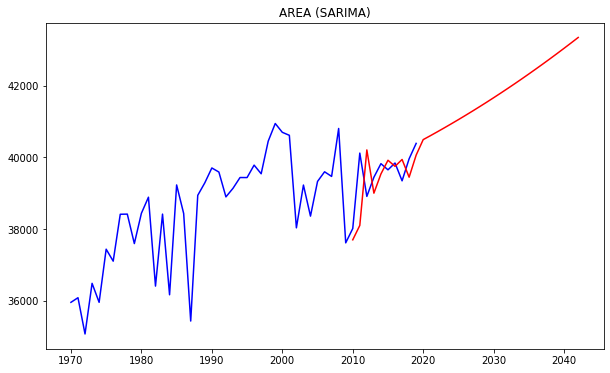

In [94]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_sarima,color='red')
plt.title("AREA (SARIMA)")

## Simple Exponential Smoothing (SES)

In [73]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
start_index = length_train+1
end_index = length+10
predicted_ses = SimpleExpSmoothing(indexedDataset['Area']).fit().predict(start = start_index, end= end_index)

In [74]:
error(indexedDataset["Area"],predicted_ses)

MAD: 513.44  
RMSE: 618.17 
MAPE: 1.29


Text(0.5, 1.0, 'AREA (SES)')

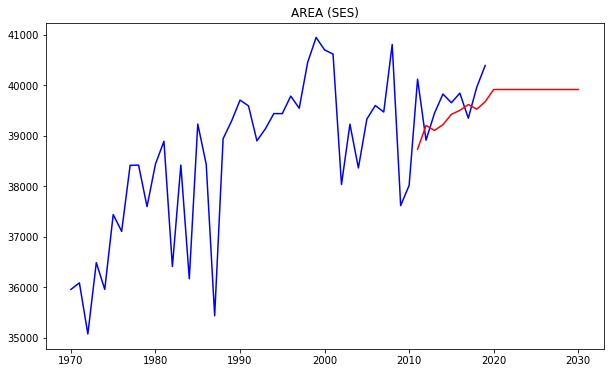

In [75]:
plt.plot(indexedDataset, color="blue")
plt.plot(predicted_ses,color='red')
plt.title("AREA (SES)")